# 07 - Evaluation on Test-Shift without Adaptation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/main/notebooks/07_evaluation_shifted_no_adaptation.ipynb)

This notebook tests the performance of a pre-trained anomaly detection model on a test-shifted dataset without any adaptation. It evaluates both image-level and pixel-level anomaly detection metrics on the model trained on clean data and uses thresholds determined from validation clean data.

**Metrics computed:**
- Image-level: AUROC, AUPRC, F1, Accuracy, Precision, Recall
- Pixel-level: Pixel AUROC, PRO (Per-Region Overlap)

## 1. Setup & Configuration

In [1]:
# ============================================================
# SETUP - Mount Google Drive & Clone Repository
# ============================================================

from google.colab import drive
from pathlib import Path
import os
import sys

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Done!\n")

# Clone repository on main branch
print("Cloning repository (branch: main)...")
repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}
print("Done!\n")

# Setup paths
PROJECT_ROOT = Path(repo_dir)

# Dataset location
DATASET_PATH = Path('/content/drive/MyDrive/mvtec_shifted')

# Output directories on Drive
DRIVE_ROOT = Path('/content/drive/MyDrive/anomaly_detection_project')
PATCHCORE_MODELS_DIR = DRIVE_ROOT / '04_patchcore_clean_outputs'
PADIM_MODELS_DIR = DRIVE_ROOT / '05_padim_clean_outputs'
CLEAN_RESULTS_DIR = DRIVE_ROOT / '06_evaluation_clean_outputs'

RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results'
VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations' / 'shifted_no_adaptation'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Verify dataset exists
if not DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATASET_PATH}\n"
        f"Please ensure mvtec_shifted folder is in your Google Drive root."
    )

# Add project root to Python path
sys.path.insert(0, str(PROJECT_ROOT))

print("\n" + "="*70)
print("SETUP COMPLETE")
print("="*70)
print(f"Project:   {PROJECT_ROOT}")
print(f"Dataset:   {DATASET_PATH}")
print(f"PatchCore: {PATCHCORE_MODELS_DIR}")
print(f"PaDiM:     {PADIM_MODELS_DIR}")
print(f"Results:   {RESULTS_DIR}")
print(f"Viz:       {VIZ_DIR}")
print("="*70)

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done!

Cloning repository (branch: main)...
Removing existing repository...
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 723, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (198/198), done.
remote: Total 723 (delta 111), reused 136 (delta 48), pack-reused 477 (from 1)
Receiving objects: 100% (723/723), 194.57 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (391/391), done.
Updating files: 100% (81/81), done.
Done!


SETUP COMPLETE
Project:   /content/Detection-of-Anomalies-with-Localization
Dataset:   /content/drive/MyDrive/mvtec_shifted
PatchCore: /content/drive/MyDrive/anomaly_detection_project/04_patchcore_clean_outputs
PaDiM:     /content/drive/MyDrive/anomaly_detection_project/05_padim_clean_outputs
Results:   /content/Detection-of-Anomal

Install both `faiss` and `anomalib` libraries, required for run PatchCore and PaDiM models respectively. **Must be done before any imports.**

In [2]:

!pip install faiss-cpu --quiet
!pip install anomalib --quiet

Import necessary libraries and modules.

In [3]:
# Standard imports
import json
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Project imports
from src.utils.reproducibility import set_seed
from src.utils.config import load_config
from src.utils.paths import ProjectPaths
from src.data.splitter import load_splits
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.models.patchcore import PatchCore
from src.models.padim_wrapper import PadimWrapper

# Metrics imports
from src.metrics import (
    compute_image_metrics,
    compute_pixel_metrics,
    compute_roc_curve,
    compute_pr_curve,
    compute_confusion_matrix,
    aggregate_metrics,
    aggregate_pixel_metrics
)

# Set random seed for reproducibility
set_seed(42)

# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Classes to evaluate
CLASSES = config.dataset.classes  # ['hazelnut', 'carpet', 'zipper']

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


def evaluation_collate(batch):
    """Custom collate function to handle None masks in batches."""
    batch = list(zip(*batch))
    images = torch.stack(batch[0])
    masks = batch[1] # Keep as tuple/list to handle None
    labels = torch.tensor(batch[2])
    paths = batch[3]
    return images, masks, labels, paths

print(f"Using device: {DEVICE}")
print(f"Classes: {CLASSES}")

Random seed set to 42 for reproducibility
Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Using device: cpu
Classes: ['hazelnut', 'carpet', 'zipper']


## 2. Load Shifted Test Metadata

In [4]:
# Load splits
SPLITS_PATH = paths.get_split_path('shifted')
splits = load_splits(SPLITS_PATH)

# Print split statistics
print("\nSplit Statistics:")
print("-" * 50)
for class_name in CLASSES:
    test_n = len(splits[class_name]['test']['images'])

    test_normal = sum(1 for l in splits[class_name]['test']['labels'] if l == 0)
    test_anom = sum(1 for l in splits[class_name]['test']['labels'] if l == 1)

    print(f"{class_name}:")
    print(f"  Test: {test_n} ({test_normal} normal, {test_anom} anomalous)")


Split Statistics:
--------------------------------------------------
hazelnut:
  Test: 89 (40 normal, 49 anomalous)
carpet:
  Test: 91 (28 normal, 63 anomalous)
zipper:
  Test: 116 (32 normal, 84 anomalous)


## 3. Load Threshold Calibrated on Val-Clean Data

For each class and method, we load threshold computed on the clean validation set.

In [5]:
# Load PatchCore thresholds
with open(CLEAN_RESULTS_DIR / 'patchcore_clean_thresholds.json', 'r') as f:
    patchcore_data = json.load(f)

# Load PaDiM thresholds
with open(CLEAN_RESULTS_DIR / 'padim_clean_thresholds.json', 'r') as f:
    padim_data = json.load(f)

# Extract only threshold fields
thresholds = {
    'patchcore': patchcore_data['thresholds'],
    'padim': padim_data['thresholds']
}

# Display loaded thresholds
print("Loaded Thresholds:")
print("=" * 60)
for method, class_thresholds in thresholds.items():
    print(f"\n{method.upper()}:")
    for class_name, threshold_value in class_thresholds.items():
        print(f"  {class_name}: {threshold_value:.4f}")


Loaded Thresholds:

PATCHCORE:
  hazelnut: 5.6441
  carpet: 2.0681
  zipper: 1.7631

PADIM:
  hazelnut: 47.4312
  carpet: 30.3877
  zipper: 24.4476


## 4. Image-Level Evaluation (Test-shifted)

Now we evaluate on the test set using the calibrated thresholds.

In [6]:
# Get transforms
transform = get_clean_transforms(image_size=config.dataset.image_size)

# Load models and evaluate on test set
all_results = {
    'patchcore': {},
    'padim': {}
}

In [7]:
# Evaluate PatchCore on each class
print("\n>>> PATCHCORE <<<")

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create test dataset
    test_split = splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=evaluation_collate
    )

    # Load model trained on CLEAN data
    model = PatchCore(
        backbone_layers=config.patchcore.layers,
        patch_size=config.patchcore.patch_size,
        coreset_ratio=config.patchcore.coreset_sampling_ratio,
        n_neighbors=config.patchcore.n_neighbors,
        device=DEVICE
    )
    model.load(PATCHCORE_MODELS_DIR, class_name, domain='clean')

    # Collect predictions
    all_scores = []
    all_labels = []
    all_heatmaps = []
    all_masks = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f'Testing {class_name}'):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_labels.extend(labels.numpy().tolist())

            for mask in masks:
                if mask is not None:
                    all_masks.append(mask.numpy().squeeze())
                else:
                    all_masks.append(None)

            all_heatmaps.extend([h for h in heatmaps])

    # Convert to arrays
    test_scores = np.array(all_scores)
    test_labels = np.array(all_labels)

    # Get threshold
    threshold = thresholds['patchcore'][class_name]

    # Compute image-level metrics
    image_metrics = compute_image_metrics(test_labels, test_scores, threshold=threshold)

    # Compute pixel-level metrics
    pixel_metrics = compute_pixel_metrics(all_masks, all_heatmaps, compute_pro_metric=True)

    # Store results
    all_results['patchcore'][class_name] = {
        'threshold': threshold,
        'image_level': image_metrics,
        'pixel_level': pixel_metrics,
        'test_scores': test_scores.tolist(),
        'test_labels': test_labels.tolist()
    }

    # Print results
    print(f"  Threshold (from clean val): {threshold:.4f}")
    print(f"  AUROC: {image_metrics['auroc']:.4f}")
    print(f"  AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics.get('accuracy', 'N/A'):.4f}")
    print(f"  Pixel AUROC: {pixel_metrics.get('pixel_auroc', 'N/A')}")
    print(f"  PRO: {pixel_metrics.get('pro', 'N/A')}")


>>> PATCHCORE <<<

--- HAZELNUT ---
✓ Using FAISS for fast k-NN search (memory bank: 12230 samples, 1536 dims)


Testing hazelnut:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (from clean val): 5.6441
  AUROC: 0.7704
  AUPRC: 0.8233
  F1: 0.7101
  Accuracy: 0.5506
  Pixel AUROC: 0.8350382790082641
  PRO: 0.7066494324737501

--- CARPET ---
✓ Using FAISS for fast k-NN search (memory bank: 8780 samples, 1536 dims)


Testing carpet:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (from clean val): 2.0681
  AUROC: 0.7874
  AUPRC: 0.9019
  F1: 0.8182
  Accuracy: 0.6923
  Pixel AUROC: 0.7455580742441463
  PRO: 0.40766846847606253

--- ZIPPER ---
✓ Using FAISS for fast k-NN search (memory bank: 7526 samples, 1536 dims)


Testing zipper:   0%|          | 0/15 [00:00<?, ?it/s]

  Threshold (from clean val): 1.7631
  AUROC: 0.3564
  AUPRC: 0.6692
  F1: 0.8400
  Accuracy: 0.7241
  Pixel AUROC: 0.7516269771283969
  PRO: 0.3725530579958771


In [8]:
# Evaluate PaDiM on each class
print("\n>>> PADIM <<<")

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create test dataset
    test_split = splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=evaluation_collate
    )

    # Load model trained on CLEAN data
    model = PadimWrapper(
        backbone=config.padim.backbone,
        layers=config.padim.layers,
        n_features=config.padim.n_features,
        image_size=config.dataset.image_size,
        device=DEVICE
    )
    model.load(PADIM_MODELS_DIR / f'padim_{class_name}_clean.pt')

    # Collect predictions
    all_scores = []
    all_labels = []
    all_heatmaps = []
    all_masks = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f'Testing {class_name}'):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            if isinstance(scores, np.ndarray):
                all_scores.extend(scores.flatten().tolist())
            else:
                all_scores.extend(scores.tolist() if hasattr(scores, 'tolist') else [float(scores)])

            all_labels.extend(labels.numpy().tolist())

            for mask in masks:
                if mask is not None:
                    all_masks.append(mask.numpy().squeeze())
                else:
                    all_masks.append(None)

            if heatmaps is not None:
                if heatmaps.ndim == 2:
                    all_heatmaps.append(heatmaps)
                else:
                    all_heatmaps.extend([h for h in heatmaps])

    # Convert to arrays
    test_scores = np.array(all_scores)
    test_labels = np.array(all_labels)

    # Get threshold
    threshold = thresholds['padim'][class_name]

    # Compute image-level metrics
    image_metrics = compute_image_metrics(test_labels, test_scores, threshold=threshold)

    # Compute pixel-level metrics
    pixel_metrics = compute_pixel_metrics(all_masks, all_heatmaps, compute_pro_metric=True)

    # Store results
    all_results['padim'][class_name] = {
        'threshold': threshold,
        'image_level': image_metrics,
        'pixel_level': pixel_metrics,
        'test_scores': test_scores.tolist(),
        'test_labels': test_labels.tolist()
    }

    # Print results
    print(f"  Threshold (from clean val): {threshold:.4f}")
    print(f"  AUROC: {image_metrics['auroc']:.4f}")
    print(f"  AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics.get('accuracy', 'N/A'):.4f}")
    print(f"  Pixel AUROC: {pixel_metrics.get('pixel_auroc', 'N/A')}")
    print(f"  PRO: {pixel_metrics.get('pro', 'N/A')}")


>>> PADIM <<<

--- HAZELNUT ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[OK] Model loaded: padim_hazelnut_clean.pt


Testing hazelnut:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (from clean val): 47.4312
  AUROC: 0.6041
  AUPRC: 0.6600
  F1: 0.7111
  Accuracy: 0.5618
  Pixel AUROC: 0.7995458677412346
  PRO: 0.5277786771421755

--- CARPET ---
[OK] Model loaded: padim_carpet_clean.pt


Testing carpet:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (from clean val): 30.3877
  AUROC: 0.8940
  AUPRC: 0.9559
  F1: 0.8676
  Accuracy: 0.8022
  Pixel AUROC: 0.9546021057389024
  PRO: 0.7374670725809731

--- ZIPPER ---
[OK] Model loaded: padim_zipper_clean.pt


Testing zipper:   0%|          | 0/15 [00:00<?, ?it/s]

  Threshold (from clean val): 24.4476
  AUROC: 0.5525
  AUPRC: 0.7828
  F1: 0.8400
  Accuracy: 0.7241
  Pixel AUROC: 0.7258757410365235
  PRO: 0.3235764135316969


## 5. Macro-Average Results

In [9]:
# Compute macro-averaged metrics
print("=" * 60)
print("MACRO-AVERAGE RESULTS (Test-Shifted, No Adaptation)")
print("=" * 60)

for method in ['patchcore', 'padim']:
    print(f"\n>>> {method.upper()} <<<")

    # Aggregate image-level metrics across all classes
    image_metrics_per_class = {
        c: all_results[method][c]['image_level']
        for c in CLASSES
    }
    macro_image = aggregate_metrics(image_metrics_per_class)

    # Aggregate pixel-level metrics across all classes
    pixel_metrics_per_class = {
        c: all_results[method][c]['pixel_level']
        for c in CLASSES
    }
    macro_pixel = aggregate_pixel_metrics(pixel_metrics_per_class)

    # Store macro-average results
    all_results[method]['macro_average'] = {
        'image_level': macro_image,
        'pixel_level': macro_pixel
    }

    print(f"\nImage-Level (macro-avg):")
    print(f"  AUROC: {macro_image.get('auroc', 'N/A'):.4f}")
    print(f"  AUPRC: {macro_image.get('auprc', 'N/A'):.4f}")
    print(f"  F1: {macro_image.get('f1', 'N/A'):.4f}")
    print(f"  Accuracy: {macro_image.get('accuracy', 'N/A'):.4f}")

    print(f"\nPixel-Level (macro-avg):")
    print(f"  Pixel AUROC: {macro_pixel.get('pixel_auroc', 'N/A'):.4f}")
    print(f"  PRO: {macro_pixel.get('pro', 'N/A'):.4f}")

MACRO-AVERAGE RESULTS (Test-Shifted, No Adaptation)

>>> PATCHCORE <<<

Image-Level (macro-avg):
  AUROC: 0.6381
  AUPRC: 0.7981
  F1: 0.7894
  Accuracy: 0.6557

Pixel-Level (macro-avg):
  Pixel AUROC: 0.7774
  PRO: 0.4956

>>> PADIM <<<

Image-Level (macro-avg):
  AUROC: 0.6835
  AUPRC: 0.7996
  F1: 0.8063
  Accuracy: 0.6960

Pixel-Level (macro-avg):
  Pixel AUROC: 0.8267
  PRO: 0.5296


## 6. Visualizations

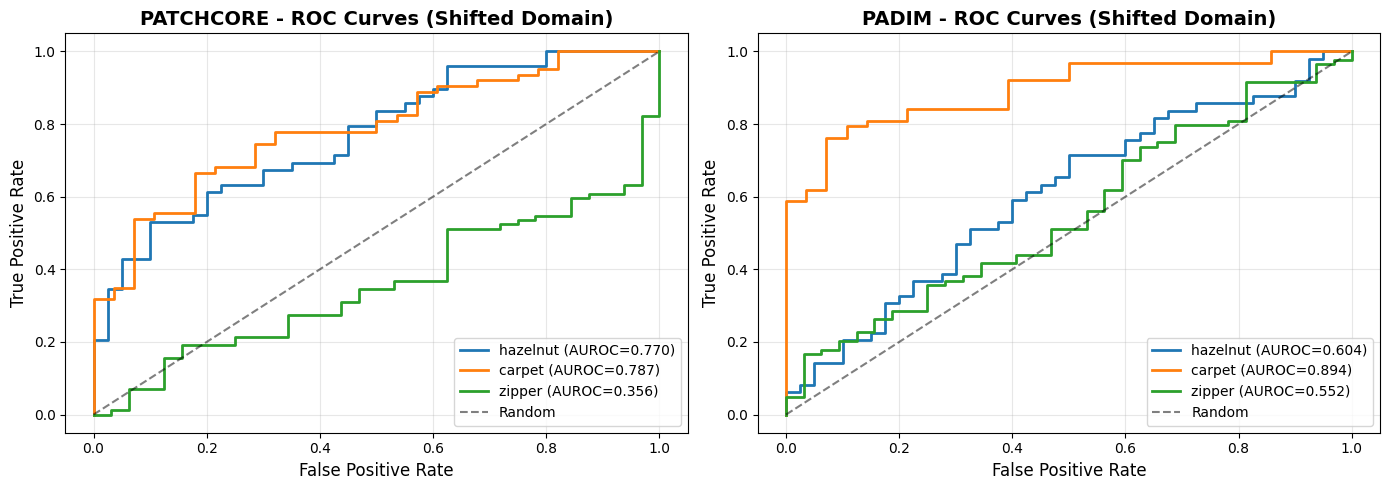

In [10]:
# ROC Curves (Test-Shifted, No Adaptation)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, method in enumerate(['patchcore', 'padim']):
    ax = axes[idx]

    for class_name in CLASSES:
        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])

        fpr, tpr, _ = compute_roc_curve(labels, scores)
        auroc = all_results[method][class_name]['image_level']['auroc']

        ax.plot(fpr, tpr, label=f'{class_name} (AUROC={auroc:.3f})', linewidth=2)

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'{method.upper()} - ROC Curves (Shifted Domain)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / 'roc_curves_shifted.png', dpi=150, bbox_inches='tight')
plt.show()

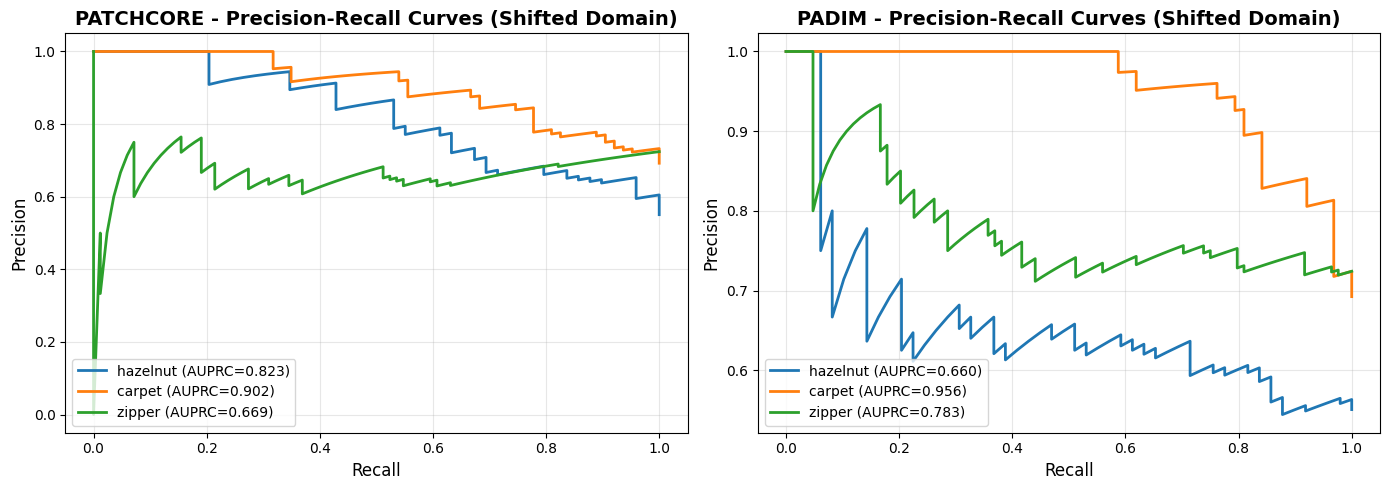

In [11]:
# Precision-Recall Curves (Test-Shifted, No Adaptation)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, method in enumerate(['patchcore', 'padim']):
    ax = axes[idx]

    for class_name in CLASSES:
        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])

        precision, recall, _ = compute_pr_curve(labels, scores)
        auprc = all_results[method][class_name]['image_level']['auprc']

        ax.plot(recall, precision, label=f'{class_name} (AUPRC={auprc:.3f})', linewidth=2)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'{method.upper()} - Precision-Recall Curves (Shifted Domain)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / 'pr_curves_shifted.png', dpi=150, bbox_inches='tight')
plt.show()

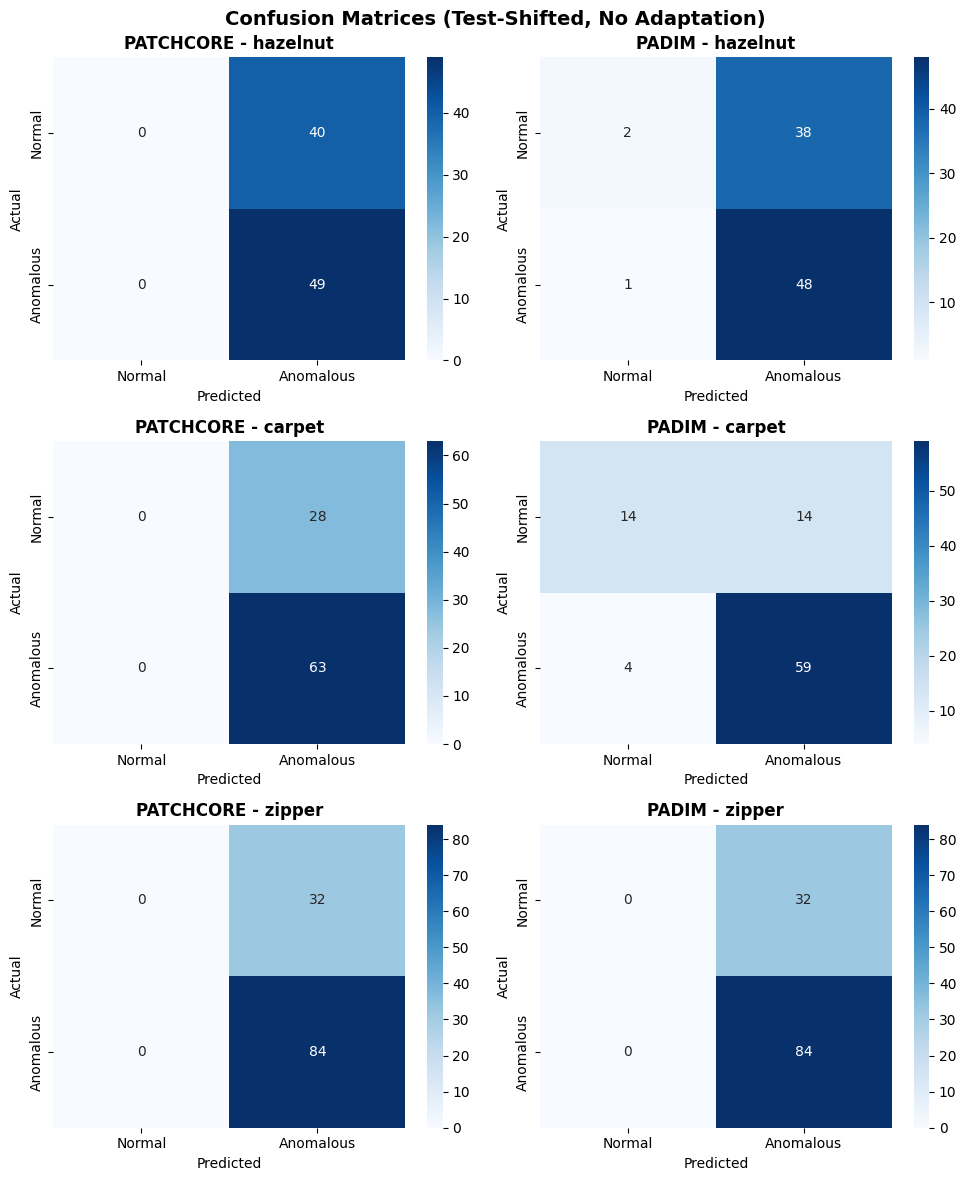

In [12]:
# Confusion Matrices (Test-Shifted, No Adaptation)
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(10, 4*len(CLASSES)))

for i, class_name in enumerate(CLASSES):
    for j, method in enumerate(['patchcore', 'padim']):
        ax = axes[i, j]

        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])
        threshold = all_results[method][class_name]['threshold']

        cm = compute_confusion_matrix(labels, scores, threshold)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Normal', 'Anomalous'],
                    yticklabels=['Normal', 'Anomalous'])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{method.upper()} - {class_name}', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices (Test-Shifted, No Adaptation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'confusion_matrices_shifted.png', dpi=150, bbox_inches='tight')
plt.show()

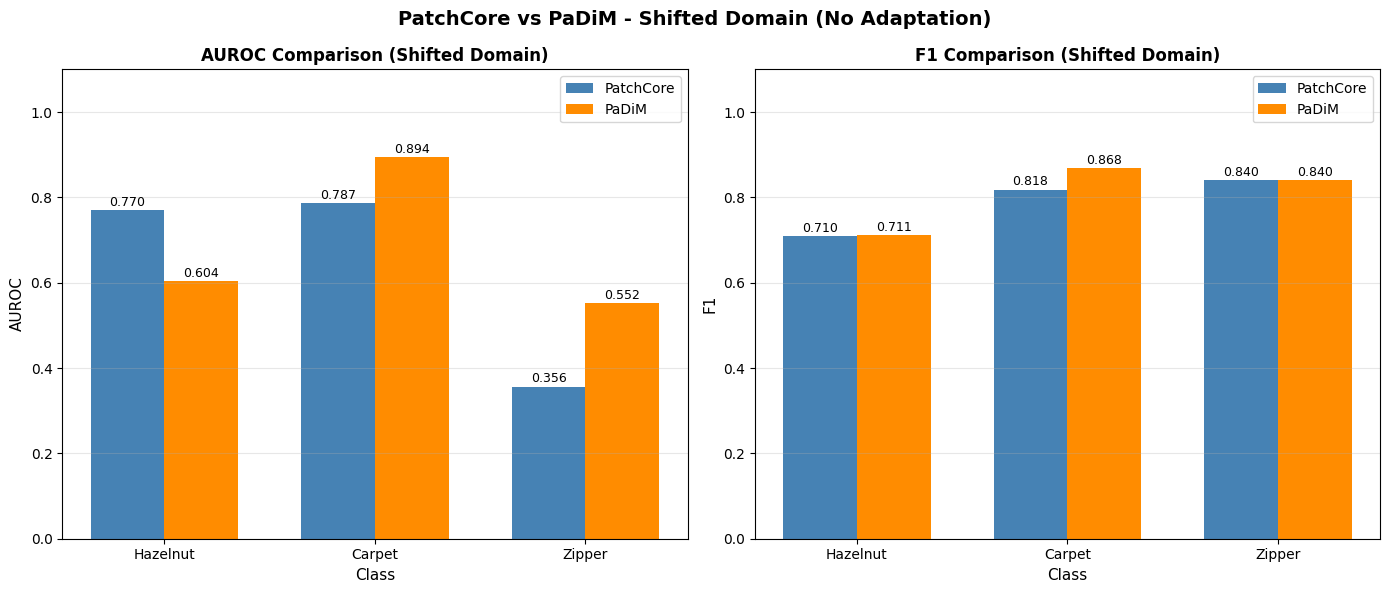

In [13]:
# Comparison Bar Plot (Test-Shifted, No Adaptation)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x = np.arange(len(CLASSES))
width = 0.35

for idx, metric in enumerate(['auroc', 'f1']):
    ax = axes[idx]

    pc_values = [all_results['patchcore'][c]['image_level'][metric] for c in CLASSES]
    pd_values = [all_results['padim'][c]['image_level'][metric] for c in CLASSES]

    bars1 = ax.bar(x - width/2, pc_values, width, label='PatchCore', color='steelblue')
    bars2 = ax.bar(x + width/2, pd_values, width, label='PaDiM', color='darkorange')

    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel(metric.upper(), fontsize=11)
    ax.set_title(f'{metric.upper()} Comparison (Shifted Domain)', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([c.capitalize() for c in CLASSES])
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

plt.suptitle('PatchCore vs PaDiM - Shifted Domain (No Adaptation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'method_comparison_shifted.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Save Results

In [14]:
# Prepare final results (Test-Shifted, No Adaptation)
final_results = {
    'metadata': {
        'notebook': '07_evaluation_shifted_no_adaptation.ipynb',
        'evaluation_type': 'Test-Shifted, No Adaptation',
        'timestamp': datetime.now().isoformat(),
        'seed': 42,
        'classes': CLASSES
    },
    'patchcore': {
        class_name: {
            'threshold': all_results['patchcore'][class_name]['threshold'],
            'image_level': all_results['patchcore'][class_name]['image_level'],
            'pixel_level': all_results['patchcore'][class_name]['pixel_level']
        }
        for class_name in CLASSES
    },
    'padim': {
        class_name: {
            'threshold': all_results['padim'][class_name]['threshold'],
            'image_level': all_results['padim'][class_name]['image_level'],
            'pixel_level': all_results['padim'][class_name]['pixel_level']
        }
        for class_name in CLASSES
    }
}

# Add macro-averages
final_results['patchcore']['macro_average'] = all_results['patchcore']['macro_average']
final_results['padim']['macro_average'] = all_results['padim']['macro_average']

# Save results
results_path = RESULTS_DIR / 'shifted_no_adaptation_results.json'
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"[OK] Results saved to: {results_path}")
print(f"[OK] Visualizations saved to: {VIZ_DIR}")

[OK] Results saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/shifted_no_adaptation_results.json
[OK] Visualizations saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_no_adaptation


## 8. Summary Table

In [15]:
import pandas as pd

# Create summary dataframe
rows = []
for method in ['patchcore', 'padim']:
    for class_name in CLASSES + ['macro_average']:
        if class_name == 'macro_average':
            img = all_results[method]['macro_average']['image_level']
            pix = all_results[method]['macro_average']['pixel_level']
            threshold = '-'
        else:
            img = all_results[method][class_name]['image_level']
            pix = all_results[method][class_name]['pixel_level']
            threshold = all_results[method][class_name]['threshold']

        rows.append({
            'Method': method.upper(),
            'Class': class_name.capitalize(),
            'Threshold': threshold if isinstance(threshold, str) else f'{threshold:.2f}',
            'AUROC': f"{img.get('auroc', 0):.4f}",
            'AUPRC': f"{img.get('auprc', 0):.4f}",
            'F1': f"{img.get('f1', 0):.4f}",
            'Accuracy': f"{img.get('accuracy', 0):.4f}",
            'Pixel AUROC': f"{pix.get('pixel_auroc', 0):.4f}" if pix.get('pixel_auroc') else '-',
            'PRO': f"{pix.get('pro', 0):.4f}" if pix.get('pro') else '-'
        })

df = pd.DataFrame(rows)
print("\n" + "=" * 100)
print("FINAL RESULTS SUMMARY - TEST-SHIFTED, NO ADAPTATION")
print("=" * 100)
print(df.to_string(index=False))

# Save as CSV
csv_path = RESULTS_DIR / 'shifted_no_adaptation_results_summary.csv'
df.to_csv(csv_path, index=False)
print(f"\n[OK] Summary saved to: {csv_path}")


FINAL RESULTS SUMMARY - TEST-SHIFTED, NO ADAPTATION
   Method         Class Threshold  AUROC  AUPRC     F1 Accuracy Pixel AUROC    PRO
PATCHCORE      Hazelnut      5.64 0.7704 0.8233 0.7101   0.5506      0.8350 0.7066
PATCHCORE        Carpet      2.07 0.7874 0.9019 0.8182   0.6923      0.7456 0.4077
PATCHCORE        Zipper      1.76 0.3564 0.6692 0.8400   0.7241      0.7516 0.3726
PATCHCORE Macro_average         - 0.6381 0.7981 0.7894   0.6557      0.7774 0.4956
    PADIM      Hazelnut     47.43 0.6041 0.6600 0.7111   0.5618      0.7995 0.5278
    PADIM        Carpet     30.39 0.8940 0.9559 0.8676   0.8022      0.9546 0.7375
    PADIM        Zipper     24.45 0.5525 0.7828 0.8400   0.7241      0.7259 0.3236
    PADIM Macro_average         - 0.6835 0.7996 0.8063   0.6960      0.8267 0.5296

[OK] Summary saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/shifted_no_adaptation_results_summary.csv


## Files Generated

This notebook generates the following files for **Test-Shifted, No Adaptation Evaluation**:

`outputs/results/`
- `shifted_no_adaptation_results.json` — Complete evaluation results in JSON format with all metrics per model and class
- `shifted_no_adaptation_results_summary.csv` — Summary table with image-level and pixel-level metrics for all models/classes

`outputs/visualizations/shifted_no_adaptation/`
- `roc_curves_shifted.png` — ROC curves with AUROC values for both PatchCore and PaDiM (image-level)
- `pr_curves_shifted.png` — Precision-Recall curves with AUPRC values for both methods (image-level)
- `confusion_matrices_shifted.png` — Confusion matrices at optimal threshold for all class/method combinations
- `method_comparison_shifted.png` — Bar chart comparing PatchCore vs PaDiM across classes (AUROC & F1)


In [16]:
import shutil
import os

# --- Configuration ---
# Destination folder on Google Drive (already configured with thresholds)
OUTPUT_DRIVE_DIR = DRIVE_ROOT / '07_shifted_no_adaptation_outputs'

# List of specific result files to save (evaluation results only)
FILES_TO_SAVE = [
    (RESULTS_DIR, 'shifted_no_adaptation_results.json'),
    (RESULTS_DIR, 'shifted_no_adaptation_results_summary.csv')
]

# Specific visualization directory for this phase
VIZ_SOURCE_DIR = VIZ_DIR

print(f"Saving evaluation outputs to: {OUTPUT_DRIVE_DIR}")

# Create base destination directory if needed
if not os.path.exists(OUTPUT_DRIVE_DIR):
    os.makedirs(OUTPUT_DRIVE_DIR, exist_ok=True)

# 1. Save result files
print("\n[Result Files]")
for source_dir, filename in FILES_TO_SAVE:
    src = source_dir / filename
    dst = OUTPUT_DRIVE_DIR / filename

    if os.path.exists(src):
        try:
            shutil.copy2(src, dst)
            print(f"Saved: {filename}")
        except Exception as e:
            print(f"Error saving {filename}: {e}")
    else:
        print(f"Warning: File not found {filename}")

# 2. Save Visualizations
print("\n[Visualizations]")
if os.path.exists(VIZ_SOURCE_DIR):
    viz_files = [f for f in os.listdir(VIZ_SOURCE_DIR) if os.path.isfile(os.path.join(VIZ_SOURCE_DIR, f))]
    if viz_files:
        for viz_filename in viz_files:
            src_viz = VIZ_SOURCE_DIR / viz_filename
            dst_viz = OUTPUT_DRIVE_DIR / viz_filename
            try:
                shutil.copy2(src_viz, dst_viz)
                print(f"Saved: {viz_filename}")
            except Exception as e:
                print(f"Error saving {viz_filename}: {e}")
    else:
        print("No visualization files found.")
else:
    print("Visualization directory not found.")

Saving evaluation outputs to: /content/drive/MyDrive/anomaly_detection_project/07_shifted_no_adaptation_outputs

[Result Files]
Saved: shifted_no_adaptation_results.json
Saved: shifted_no_adaptation_results_summary.csv

[Visualizations]
Saved: roc_curves_shifted.png
Saved: confusion_matrices_shifted.png
Saved: method_comparison_shifted.png
Saved: pr_curves_shifted.png
